<a href="https://colab.research.google.com/github/haeniKim/multi_project3/blob/master/CNN_Snack_1_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN 모델 생성
### 과자 10종 분류 모델
* Train_Data : 1161 -> Train / Validation 9:1
* Test_Data : 129

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

# I. Google Drive Mount
* 이미지 데이터 불러오기

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# II. Data Preprocessing

> ## 1) Create Image_File DataFrame

In [ ]:
dir_ = Path('/content/drive/MyDrive/Colab Notebooks/datasets/new_snack')
filepaths = list(dir_.glob(r'**/*.jpg'))

def proc_img(filepath):

    labels = [str(filepath[i]).split("/")[-2] for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

df = proc_img(filepaths)
df.head()

,Filepath,Label
0,/content/drive/MyDrive/Colab Notebooks/dataset...,pie
1,/content/drive/MyDrive/Colab Notebooks/dataset...,turtle
2,/content/drive/MyDrive/Colab Notebooks/dataset...,banana
3,/content/drive/MyDrive/Colab Notebooks/dataset...,pizza
4,/content/drive/MyDrive/Colab Notebooks/dataset...,banana


## 2) Data EDA

In [ ]:
print('The number of pictures:', df.shape[0])
print('The number of snacks:', len(df.Label.unique()))
print('Labels:', df.Label.unique())

The number of pictures: 1290
The number of snacks: 10
Labels: ['pie' 'turtle' 'banana' 'pizza' 'shrimp' 'chip' 'onion' 'oreo' 'heim'
 'pepero']


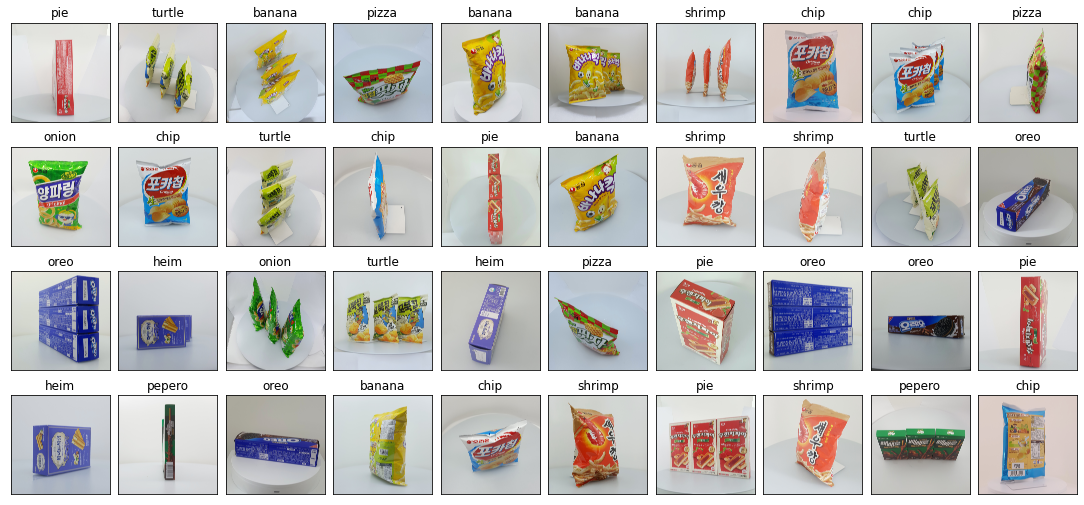

In [ ]:
# 데이터 확인
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

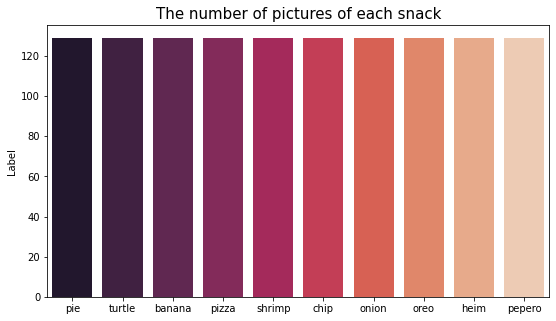

In [ ]:
vc = df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("The number of pictures of each snack", fontsize = 15)
plt.show()

## 3) Train / Test Split 

In [ ]:
train_df,test_df = train_test_split(df, test_size=0.1,random_state=0)
train_df.shape,test_df.shape

((1161, 2), (129, 2))

## 4) ImageDataGenerator( ) & flow_from_dataframe( )

* Normalization
 * ImageDataGenerator( )
* Resizing & Generator
 * flow_from_dataframe( )

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split=0.1)

train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    x_col='Filepath',
                                                    y_col='Label',
                                                    target_size=(75, 75),
                                                    batch_size=16,
                                                    class_mode='categorical',
                                                    subset='training')

valid_generator  = train_datagen.flow_from_dataframe(train_df,
                                                     x_col='Filepath',
                                                     y_col='Label',
                                                     target_size=(75, 75),
                                                     batch_size=16,
                                                     class_mode='categorical',
                                                     subset='validation')


Found 1045 validated image filenames belonging to 10 classes.
Found 116 validated image filenames belonging to 10 classes.


> ## 4) Test train_generator

In [ ]:
for data_batch, labels_batch in train_generator:
    print('배치 데이터 크기:', data_batch.shape)
    print('배치 레이블 크기:', labels_batch.shape)
    break

배치 데이터 크기: (16, 75, 75, 3)
배치 레이블 크기: (16, 10)


In [ ]:
labels_batch

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

# III. CNN Keras Modeling

> ## 1) Model Define

* Feature Extraction & Classification

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (75, 75, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(10, activation = 'softmax'))

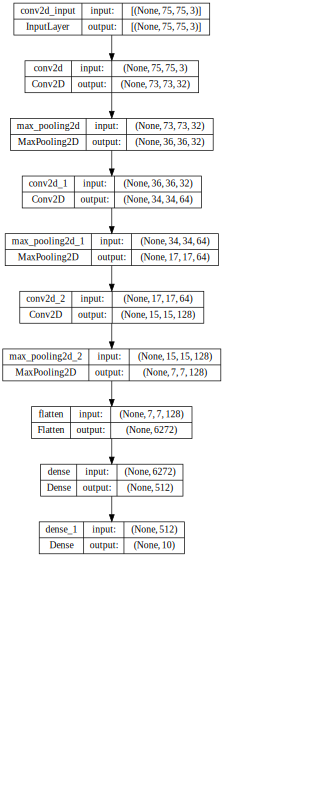

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

dot_res = model_to_dot(model,show_shapes=True, dpi=50).create(prog='dot', format='svg')
fi = open("model_cnn_1.svg", 'wb')
fi.write(dot_res)
fi.close()

SVG(dot_res)



In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 73, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 36, 36, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 17, 17, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 7, 7, 128)        0

> ## 2) Model Compile

* 모델 학습방법 설정

In [ ]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

> ## 3) Model Fit

* 약 분 소요

In [ ]:
%%time

Hist_dandc = model.fit(train_generator,
                       steps_per_epoch = 65,
                       epochs = 100,
                       validation_data = valid_generator,
                       validation_steps = 8)

Epoch 1/100
65/65 [==============================] - 742s 11s/step - loss: 1.6024 - accuracy: 0.4286 - val_loss: 0.8720 - val_accuracy: 0.6552
Epoch 2/100
65/65 [==============================] - 125s 2s/step - loss: 0.4837 - accuracy: 0.8328 - val_loss: 0.2920 - val_accuracy: 0.9052
Epoch 3/100
65/65 [==============================] - 122s 2s/step - loss: 0.2355 - accuracy: 0.9155 - val_loss: 0.1848 - val_accuracy: 0.9569
Epoch 4/100
65/65 [==============================] - 125s 2s/step - loss: 0.1928 - accuracy: 0.9378 - val_loss: 0.2790 - val_accuracy: 0.9052
Epoch 5/100
65/65 [==============================] - 123s 2s/step - loss: 0.1264 - accuracy: 0.9631 - val_loss: 0.4744 - val_accuracy: 0.8707
Epoch 6/100
65/65 [==============================] - 124s 2s/step - loss: 0.1702 - accuracy: 0.9446 - val_loss: 0.1789 - val_accuracy: 0.9310
Epoch 7/100
65/65 [==============================] - 124s 2s/step - loss: 0.0341 - accuracy: 0.9913 - val_loss: 0.0170 - val_accuracy: 0.9914
Epoch

> ## 4) Loss & Accuracy Visualization

* Loss Visualization

In [ ]:
print(Hist_dandc.history['val_loss'])
print(Hist_dandc.history['loss'])

[0.8719843626022339, 0.2920058071613312, 0.1847734898328781, 0.27898943424224854, 0.47443434596061707, 0.17885802686214447, 0.016959507018327713, 0.03236166760325432, 0.19893324375152588, 0.049523793160915375, 0.013789200223982334, 0.23751652240753174, 0.03375524654984474, 0.021183935925364494, 0.012634334154427052, 0.013928533531725407, 0.014369920827448368, 0.013828566297888756, 0.016219496726989746, 0.013827692717313766, 0.015046391636133194, 0.0162216667085886, 0.015430787578225136, 0.017649423331022263, 0.017750557512044907, 0.017331136390566826, 0.021224666386842728, 0.016497846692800522, 0.01928623765707016, 0.02107151411473751, 0.018689071759581566, 0.021173419430851936, 0.021285925060510635, 0.02243136055767536, 0.02341894991695881, 0.02408614568412304, 0.0256482046097517, 0.01944231614470482, 0.021984238177537918, 0.027568306773900986, 0.02444877289235592, 0.02253735065460205, 0.024187251925468445, 0.02470952458679676, 0.0224609375, 0.025909919291734695, 0.026847098022699356,

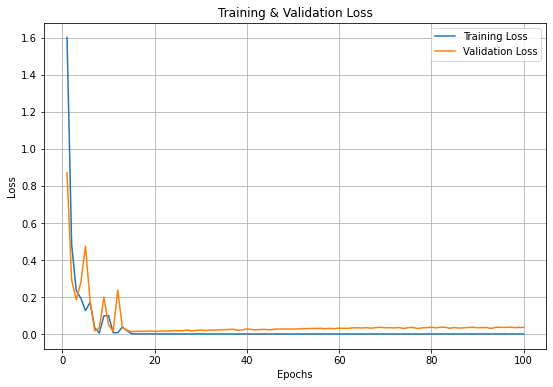

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist_dandc.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, Hist_dandc.history['loss'])
plt.plot(epochs, Hist_dandc.history['val_loss'])

plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.show()

* Accuracy Visualization

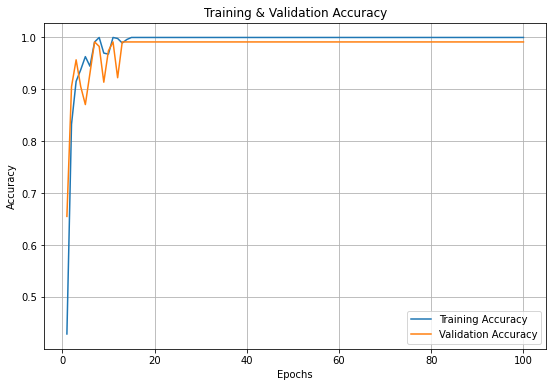

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist_dandc.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, Hist_dandc.history['accuracy'])
plt.plot(epochs, Hist_dandc.history['val_accuracy'])

plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.grid()
plt.show()

> ## 5) Model Evaluate


* test_generator

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_dataframe(test_df,
                                                  x_col='Filepath',
                                                  y_col='Label',
                                                  target_size=(75, 75),
                                                  batch_size=16)

Found 129 validated image filenames belonging to 10 classes.


* Loss & Accuracy

In [ ]:
loss, accuracy = model.evaluate(test_generator)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

9/9 [==============================] - 71s 9s/step - loss: 8.5298e-05 - accuracy: 1.0000
Loss = 0.00009
Accuracy = 1.00000


## 6) Model Saving

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/models/snack_cnn_1.h5')

In [ ]:
!ls -l /content/drive/My\ Drive/Colab\ Notebooks/models

total 38845
-rw------- 1 root root 39777040 Nov 22 06:35 snack_cnn_1.h5


### 7) Model Load

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.models import load_model

model_1 = load_model('/content/drive/My Drive/Colab Notebooks/models/snack_cnn_1.h5')